Libraries:

In [32]:
# Thêm các thư viện
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error

In [33]:
# Lấy dữ liệu từ Data
url = "../../../Data/number_of_deaths_processed_data.csv"

# Đọc file 
deaths = pd.read_csv(url)
deaths

,Prematurity,Birth asphyxia and birth trauma,Sepsis and other infectious conditions of the newborn,Congenital anomalies,Injuries,Tuberculosis,Other Group 1 and Other noncommunicable (neonatal and under-5 only),HIV/AIDS,Diarrhoeal diseases,Tetanus,Measles,Meningitis/encephalitis,Malaria,Acute lower respiratory infections,CountryName,Year
0,19333.41926,11691.37210,4489.50404,1534.08344,371.28902,0.0,10579.92644,0.22891,1973.08786,2331.69796,0.0,1395.33839,0.0,6908.05259,Afghanistan,2000
1,14761.72219,10042.87869,2977.92908,1405.50824,130.32201,0.0,3849.14708,30.31433,724.01316,768.57928,0.0,357.27433,0.0,4267.31161,Angola,2000
2,351.16760,110.05251,17.54192,106.22332,4.31283,0.0,30.48989,0.00347,0.77210,0.09764,0.0,10.36631,0.0,36.97242,Albania,2000
3,3.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.0,0.00000,Andorra,2000
4,137.90854,26.85080,2.86905,75.66284,1.78464,0.0,66.57905,0.10435,0.00000,0.00000,0.0,0.15043,0.0,0.09029,United Arab Emirates,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4263,17.45855,5.56010,2.93639,7.28102,0.25978,0.0,4.18806,0.00000,0.00000,0.00000,0.0,0.15554,0.0,1.16055,Samoa,2021
4264,11286.37393,6796.63328,1742.58956,2227.89226,229.08594,0.0,3051.97336,0.90444,521.35998,129.94279,0.0,44.07145,0.0,2523.17301,Yemen,2021
4265,4634.07215,2595.54661,1828.98610,1315.87236,166.21530,0.0,1708.85383,36.14888,0.00000,0.00000,0.0,16.01934,0.0,677.28544,South Africa,2021
4266,6920.62510,4054.12780,912.70245,1274.53105,35.09944,0.0,1776.66284,22.93804,134.08604,23.52546,0.0,108.91078,0.0,1228.79101,Zambia,2021


***DỰ ĐOÁN TỔNG SỐ CA TỬ VONG TOÀN CẦU***

Chia ra label và feature
- Label: Injuries - số ca tử vong do chấn thương
- Features: các nguyên do khác

Lý do chia ra label và feature:

- Huấn luyện mô hình: Mô hình máy học cần học cách dự đoán một biến dự báo (label) dựa trên thông tin từ các biến khác (features). Bằng cách chia nhỏ dữ liệu thành label và features, mô hình có thể học cách liên kết giữa các features và label để tạo ra các dự đoán chính xác.

- Phân loại công việc: Bằng cách xác định label và features, xác định được nhiệm vụ của mô hình. Label là điều mà mô hình cố gắng dự đoán, trong khi features là thông tin mà mô hình sử dụng để thực hiện dự đoán.

- Tiền xử lý dữ liệu: Chia ra label và features giúp áp dụng các kỹ thuật tiền xử lý dữ liệu riêng biệt cho từng loại. 

- Đánh giá hiệu suất: Khi mô hình đã được huấn luyện, việc chia ra label và features cũng giúp đánh giá hiệu suất của mô hình bằng cách so sánh giữa label thực tế và label dự đoán được từ features.

In [34]:
# X là DataFrame chứa các features sau khi loại bỏ cột Injuries
X = deaths.drop(columns = 'Injuries')

# Y chứa label Injuries
Y = deaths['Injuries']

# Cột CountryName thường không thể dùng trực tiếp trong mô hình máy học do giá trị chuỗi 
# nên được mã hóa sang dạng số sử dụng LabelEncoder từ thư viện sklearn
LE = LabelEncoder()
X['CountryName'] = LE.fit_transform(X['CountryName'])

Tạo train, test set:

In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .3, random_state = 42)

Khởi tạo model

In [36]:
# Xác định mô hình hồi quy tuyến tính 
LR = LinearRegression()

# Huấn luyện mô hình với dữ liệu huấn luyện đã chia
LR.fit(X_train, Y_train)

LinearRegression()

Dự đoán khi dùng model

In [37]:
# Dự đoán số ca tử vong toàn cầu
total_deaths_pred = LR.predict(X_test)

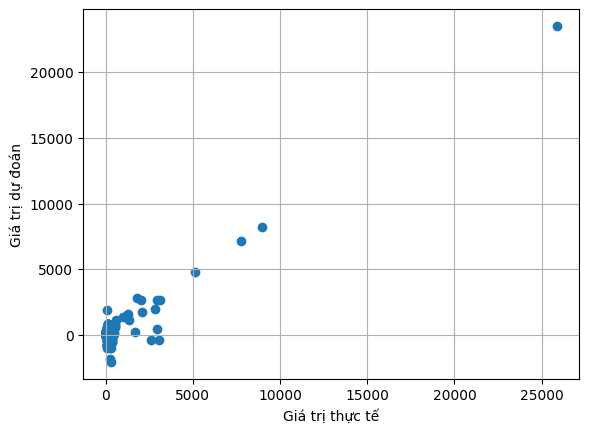

In [38]:
# Biểu đồ của số ca tử vong toàn cầu
plt.scatter(Y_test, total_deaths_pred)
plt.xlabel("Giá trị thực tế")
plt.ylabel("Giá trị dự đoán")
plt.grid(True)
plt.show()

Đánh giá:

In [39]:
# @title
MSE = mean_squared_error(Y_test, total_deaths_pred)
MSE


61785.42950305886

***DỰ ĐOÁN SỐ CA TỬ VONG DO SINH NON***

In [40]:
cleaned_df = pd.read_csv("../../../Data/number_of_deaths_processed_data.csv")
df_copy = cleaned_df.copy()
df_copy = df_copy.drop(['CountryName'], axis='columns')

In [41]:
# Tính ma trận tương quan
correlation_matrix = df_copy.corr()

Định nghĩa tỷ lệ số năm

In [63]:
# Tạo danh sách các năm từ 2000 đến 2021
years = list(range(2000, 2022))

# Tính số lượng dòng tương ứng với từng phần
train_years = 13
val_years = 4
test_years = 5

# Tính số dòng tương ứng cho mỗi phần
total_years = train_years + val_years + test_years
train_data_years = int(len(df_copy) * (train_years / total_years))
val_data_years = int(len(df_copy) * (val_years / total_years))

print(train_data_years)
print(val_data_years)

2522
776


In [94]:
# Chia dữ liệu thành training, validation, test theo tỉ lệ
train_data = df_copy[df_copy['Year'].isin(range(2000, 2014))]
val_data = df_copy[df_copy['Year'].isin(range(2014, 2018))]
test_data = df_copy[df_copy['Year'].isin(range(2018, 2022))]

Xây dựng mô hình

Đầu tiên dùng cặp dữ liệu X_train và y_train để huấn luyện mô hình

Lý do chọn Prematurity vì dựa trên việc mất do sinh non có thể có tác động lớn đối với sức khỏe của một quốc gia.

In [70]:
# Chia mỗi tập thành features và label
X_train = train_data.drop(columns=['Prematurity']) 
y_train = train_data['Prematurity']

X_val = val_data.drop(columns=['Prematurity'])
y_val = val_data['Prematurity']

X_test = test_data.drop(columns=['Prematurity'])
y_test = test_data['Prematurity']

Chia ra label và feature
- Label: Injuries - số ca tử vong do sinh non
- Features: các nguyên do khác

Lý do chia ra label và feature:

- Huấn luyện mô hình: Mô hình máy học cần học cách dự đoán một biến dự báo (label) dựa trên thông tin từ các biến khác (features). Bằng cách chia nhỏ dữ liệu thành label và features, mô hình có thể học cách liên kết giữa các features và label để tạo ra các dự đoán chính xác.

- Phân loại công việc: Bằng cách xác định label và features, xác định được nhiệm vụ của mô hình. Label là điều mà mô hình cố gắng dự đoán, trong khi features là thông tin mà mô hình sử dụng để thực hiện dự đoán.

- Tiền xử lý dữ liệu: Chia ra label và features giúp áp dụng các kỹ thuật tiền xử lý dữ liệu riêng biệt cho từng loại. 

- Đánh giá hiệu suất: Khi mô hình đã được huấn luyện, việc chia ra label và features cũng giúp đánh giá hiệu suất của mô hình bằng cách so sánh giữa label thực tế và label dự đoán được từ features.

In [92]:
# Huấn luyện mô hình Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [95]:
# Dự đoán trên tập validation và test
predicted_val = model.predict(X_val)
predicted_test = model.predict(X_test)

Thước đo 'neg_mean_squared_error' (độ lỗi bình phương trung bình âm) được sử dụng để đo lường hiệu suất của mô hình. Khi sử dụng thước đo này, kết quả trả về sẽ là các giá trị MSE âm. Lý do là để phù hợp với cấu trúc của hàm cross_val_score trong thư viện Scikit-learn. Bởi vì phần lớn các hàm trong Scikit-learn đánh giá hiệu suất dựa trên độ chính xác hoặc độ lỗi

In [72]:
# Sử dụng cross-validation để xác thực siêu tham số
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_scores

array([-2876254.58397805, -1843318.21643644, -1587391.46165029,
       -1887730.41828787, -1541522.70828086])

Khi sử dụng scoring='neg_mean_squared_error', điểm số được trả về sẽ là giá trị âm của MSE, có nghĩa là mô hình càng tốt nếu giá trị này càng cao. Sau khi hoàn thiện cross-validation, ta có thể đổi dấu của kết quả để lấy giá trị MSE dương thực sự. Điều này giúp cho việc so sánh và đánh giá hiệu suất dễ dàng hơn, với giá trị MSE càng nhỏ thể hiện mô hình càng tốt.

In [96]:
# Đánh giá hiệu suất mô hình
mse_scores = -cv_scores
mean_mse = mse_scores.mean() 
root_mean_mse = np.sqrt(mean_mse)

Giá trị Độ lỗi bình phương trung bình cao

Giá trị Căn bậc hai độ lỗi bình phương trung bình nhỏ

Vậy nên hiệu suất mô hình là tốt

In [97]:
# Báo cáo quy trình tinh chỉnh mô hình
print(f"Độ lỗi bình phương trung bình: {mean_mse}")
print(f"Căn bậc hai độ lỗi bình phương trung bình : {root_mean_mse}")

Độ lỗi bình phương trung bình: 1947243.4777267028
Căn bậc hai độ lỗi bình phương trung bình : 1395.436662026157


Đánh giá hiệu suất trên tập validation, kết quả tốt

In [101]:
r_squared_val = model.score(X_val, y_val) 
r_squared_val

0.9958823511674643

Đánh giá hiệu suất trên tập test, kết quả tốt

In [102]:
r_squared_test = model.score(X_test, y_test)
r_squared_test

0.9938629617776761

In [103]:
# In tổng số ca tử vong dự đoán
total_predicted_values = 0
total_predicted_values += sum(predicted_test)
print("Tổng ca tử vong do sinh non:")
print(total_predicted_values)

Tổng ca tử vong do sinh non:
3545881.62004786


Vẽ biểu đồ

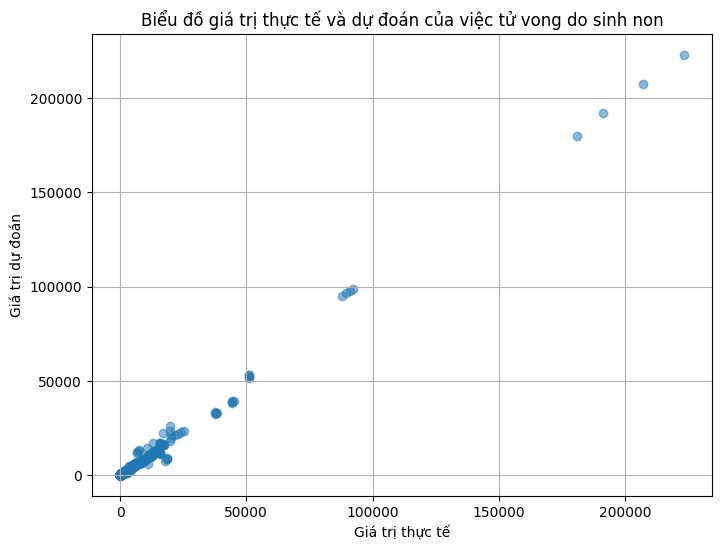

In [107]:
# Vẽ biểu đồ
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predicted_test, alpha=0.5)
plt.xlabel("Giá trị thực tế")
plt.ylabel("Giá trị dự đoán")
plt.title("Biểu đồ giá trị thực tế và dự đoán của việc tử vong do sinh non")
plt.grid(True)
plt.show()